In [164]:
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.filters import threshold_otsu
from skimage.morphology import disk, white_tophat, black_tophat

In [165]:
# Load and preprocess image
def load_and_preprocess_image(path, size=(512, 512)):

  '''

  Args:

  Returns:

  '''

  img_bgr = cv2.imread(path)
  img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, size)
  green_channel = img[:, :, 1]  # Green channel

  return img, green_channel

In [166]:
# Apply CLAHE and histogram equalization
def enhance_image(green_channel):

  '''

  Args:

  Returns:

  '''

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  clahe_img = clahe.apply(green_channel)
  equalized_img = cv2.equalizeHist(clahe_img)

  return equalized_img

In [167]:
def detect_exudates(image_path):

  '''

  Args:

  Returns:

  '''

  img, green = load_and_preprocess_image(image_path, size=(512, 512))

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

  # Top-hat highlights small bright areas (like exudates)
  tophat = cv2.morphologyEx(green, cv2.MORPH_TOPHAT, kernel)

  # Bottom-hat highlights dark areas surrounded by bright (background model)
  bothat = cv2.morphologyEx(green, cv2.MORPH_BLACKHAT, kernel)

  # Emphasize exudates by subtracting background
  enhanced = cv2.subtract(tophat, bothat)

  # Threshold to binary
  _, binary = cv2.threshold(enhanced, 20, 255, cv2.THRESH_BINARY)

  return binary

In [168]:
def detect_blood_vessels(image_path):

  '''

  Args:

  Returns:

  '''

  # Step 1: Extract green channel
  img, green_channel = load_and_preprocess_image(image_path, size=(512, 512))

  # Step 2: Apply CLAHE for contrast enhancement
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  enhanced = clahe.apply(green_channel)

  # Step 3: Morphological blackhat (to highlight dark vessels)
  selem = disk(8)  # adjust radius based on vessel size
  blackhat = black_tophat(enhanced, selem)

  # Step 4: Apply Otsu's thresholding
  _, vessel_mask = cv2.threshold(blackhat, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  return vessel_mask

In [169]:
def detect_optic_disc(image_path, threshold=240):

  '''

  Args:

  Returns:

  '''

  img, green_channel = load_and_preprocess_image(image_path, size=(512, 512))

  # Apply histogram equalization
  equalized = cv2.equalizeHist(green_channel)

  # Normalize histogram
  norm = cv2.normalize(equalized, None, 0, 255, cv2.NORM_MINMAX)

  # Threshold to detect brightest areas (optic disc)
  _, disc = cv2.threshold(norm, threshold, 255, cv2.THRESH_BINARY)

  return disc, equalized



def visualize_optic_disc(img_path, green_channel):

  '''

  Args:

  Returns:

  '''

  disc_mask, enhanced = detect_optic_disc(img_path)

  # Convert green channel to RGB for overlay
  overlay = cv2.cvtColor(green_channel, cv2.COLOR_GRAY2BGR)

  # Draw detected circle from disc mask
  contours, _ = cv2.findContours(disc_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
      (x, y), radius = cv2.minEnclosingCircle(cnt)
      center = (int(x), int(y))
      radius = int(radius)
      cv2.circle(overlay, center, radius, (0, 255, 0), 2)

  # Plot each stage
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(green_channel, cmap='gray')
  plt.title("Original Green Channel")
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(enhanced, cmap='gray')
  plt.title("CLAHE Enhanced")
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(overlay)
  plt.title("Detected Optic Disc")
  plt.axis('off')

  plt.tight_layout()
  plt.show()

In [170]:
# Visualization helper
def show_images(title, images):

  '''

  Args:

  Returns:

  '''

  plt.figure(figsize=(15, 10))
  for i, (name, img) in enumerate(images.items()):
      plt.subplot(2, 3, i + 1)
      plt.imshow(img, cmap='gray')
      plt.title(name)
      plt.axis('off')

  plt.suptitle(title)
  plt.show()

In [171]:
# Function to compute area (in pixels) of binary masks
def compute_area(binary_mask):

  '''

  Args:

  Returns:

  '''

  return np.sum(binary_mask > 0)


# Example usage with dummy variables (to be replaced with real image inputs)
def compute_feature_areas(image_path, threshold):

  '''

  Args:

  Returns:

  '''

  # Load and preprocess
  rgb_img, green_channel = load_and_preprocess_image(image_path)
  enhanced = enhance_image(green_channel)

  # Detect features
  exudates = detect_exudates(image_path)
  vessels = detect_blood_vessels(image_path)
  optic_disc, _ = detect_optic_disc(image_path, threshold)

  # Compute areas
  area_exudates = compute_area(exudates)
  area_vessels = compute_area(vessels)
  area_optic_disc = compute_area(optic_disc)

  return {
            "Exudates Area (px)": area_exudates,
            "Blood Vessels Area (px)": area_vessels,
            "Optic Disc Area (px)": area_optic_disc
        }

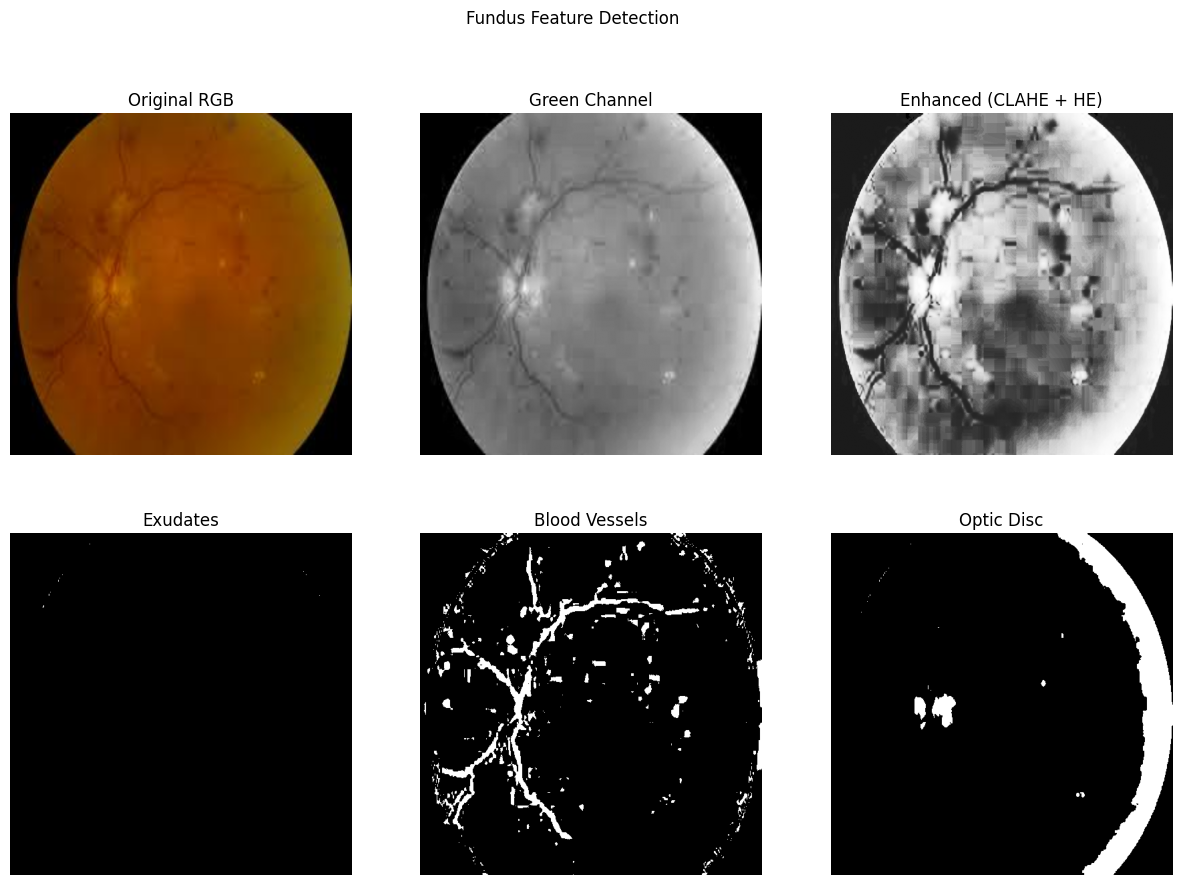

{'Exudates Area (px)': np.int64(18),
 'Blood Vessels Area (px)': np.int64(17029),
 'Optic Disc Area (px)': np.int64(22874)}

In [172]:
# Example usage
img_path = '/content/diabetic_retinopathy_sample.jpg'
rgb_img, green_channel = load_and_preprocess_image(img_path)

enhanced = enhance_image(green_channel)
exudates = detect_exudates(img_path)
vessels = detect_blood_vessels(img_path)
optic_disc, _ = detect_optic_disc(img_path, threshold=230)

show_images("Fundus Feature Detection", {
                                            "Original RGB": rgb_img,
                                            "Green Channel": green_channel,
                                            "Enhanced (CLAHE + HE)": enhanced,
                                            "Exudates": exudates,
                                            "Blood Vessels": vessels,
                                            "Optic Disc": optic_disc
                                        })

#
# visualize_optic_disc(img_path, green_channel)


# Test the area calculation
compute_feature_areas(img_path, threshold=230)

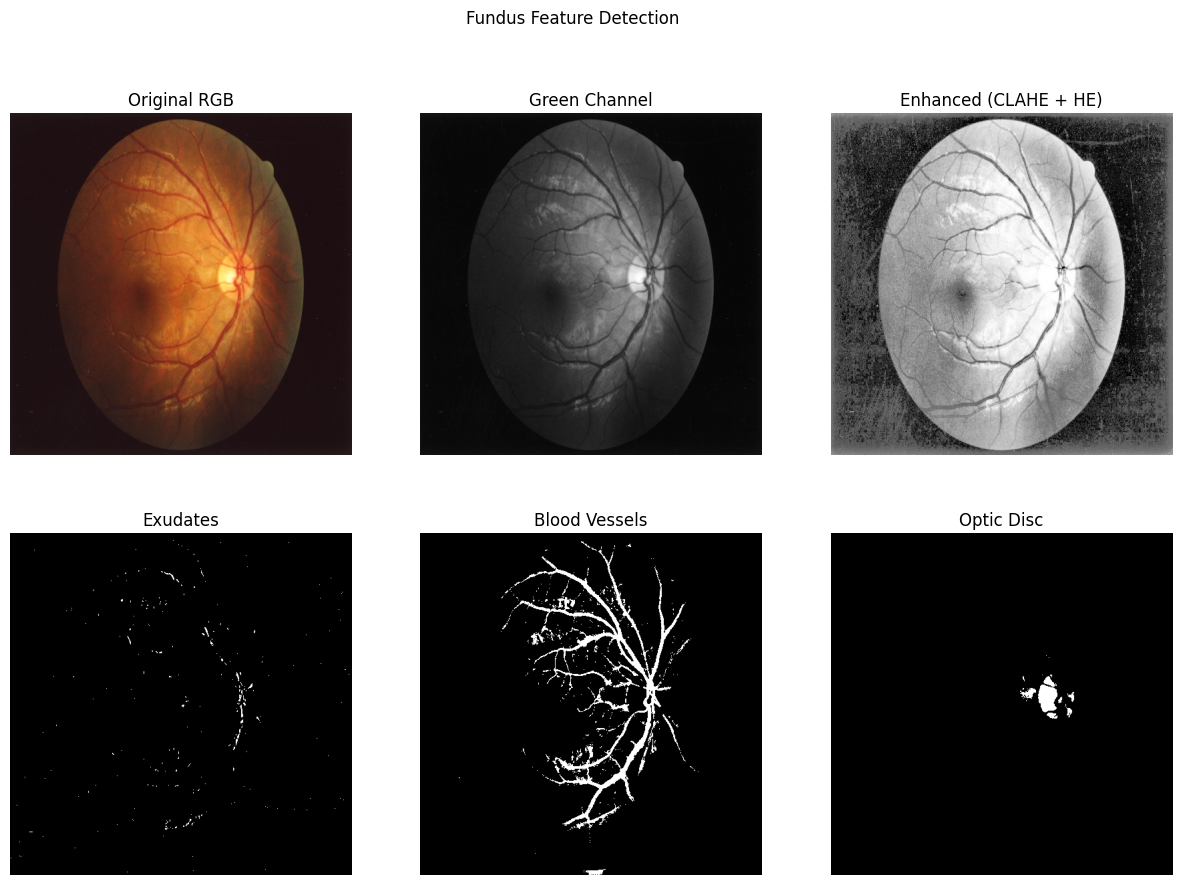

{'Exudates Area (px)': np.int64(845),
 'Blood Vessels Area (px)': np.int64(12978),
 'Optic Disc Area (px)': np.int64(1571)}

In [173]:
# Example usage
img_path = '/content/Fundus_of_eye_normal.jpg'
rgb_img, green_channel = load_and_preprocess_image(img_path)

enhanced = enhance_image(green_channel)
exudates = detect_exudates(img_path)
vessels = detect_blood_vessels(img_path)
optic_disc, _ = detect_optic_disc(img_path, threshold=253)

show_images("Fundus Feature Detection", {
                                            "Original RGB": rgb_img,
                                            "Green Channel": green_channel,
                                            "Enhanced (CLAHE + HE)": enhanced,
                                            "Exudates": exudates,
                                            "Blood Vessels": vessels,
                                            "Optic Disc": optic_disc
                                        })

#
# visualize_optic_disc(img_path, green_channel)


# Test the area calculation on an example image
compute_feature_areas(img_path, threshold=253)

In [ ]:
# # Exudate detection using morphological top-hat and bottom-hat
# def detect_exudates(green_channel):
#     selem = disk(12)
#     bottom_hat = black_tophat(green_channel, selem)
#     top_hat = white_tophat(green_channel, selem)
#     exudate_candidate = cv2.subtract(top_hat, bottom_hat)
#     _, binary_exudates = cv2.threshold(exudate_candidate, 28, 255, cv2.THRESH_BINARY)
#     return binary_exudates



# def apply_kirsch_filter(image):

#     """
#     Apply all 8 Kirsch filters and take maximum response.
#     """

#     kirsch_kernels = [
#                         np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),  # North
#                         np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]),  # NE
#                         np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]),  # East
#                         np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]),  # SE
#                         np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]),  # South
#                         np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]),  # SW
#                         np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]),  # West
#                         np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]),  # NW
#                     ]

#     responses = [cv2.filter2D(image, -1, k) for k in kirsch_kernels]
#     max_response = np.max(responses, axis=0)

#     return max_response




# def detect_blood_vessels(image_path):

#     """
#     Full pipeline: CLAHE → Blackhat → Kirsch → Otsu
#     """

#     # Step 1: Load and extract green channel
#     img, green = load_and_preprocess_image(image_path)

#     # Step 2: Enhance contrast with CLAHE
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced = clahe.apply(green)

#     # Step 3: Black-hat filtering (optional but helps)
#     blackhat = black_tophat(enhanced, disk(8))

#     # Step 4: Apply Kirsch filtering
#     kirsch_response = apply_kirsch_filter(blackhat)

#     # Step 5: Threshold using Otsu
#     thresh_val = threshold_otsu(kirsch_response)
#     binary_mask = (kirsch_response > thresh_val).astype(np.uint8) * 255

#     return binary_mask


# # Optic disc detection using histogram normalization and thresholding
# def detect_optic_disc(green_channel, threshold=100, min_radius=30, max_radius=100):

#     # Step 1: Enhance contrast using CLAHE
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced = clahe.apply(green_channel)

#     # Step 2: Threshold to keep bright areas
#     _, thresh = cv2.threshold(enhanced, threshold, 255, cv2.THRESH_BINARY)

#     # Step 3: Morphological cleanup (remove small blobs)
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

#     # Step 4: Find contours (possible optic disc candidates)
#     contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Step 5: Select the best circular region by radius and circularity
#     disc_mask = np.zeros_like(green_channel, dtype=np.uint8)
#     best_score = 0
#     for cnt in contours:

#         area = cv2.contourArea(cnt)
#         perimeter = cv2.arcLength(cnt, True)

#         if perimeter == 0:
#             continue

#         circularity = 4 * np.pi * (area / (perimeter ** 2))

#         # Fit a circle
#         ((x, y), radius) = cv2.minEnclosingCircle(cnt)

#         if min_radius < radius < max_radius and circularity > 0.3:

#             # High circularity means more likely to be optic disc
#             if area > best_score:
#                 best_score = area
#                 cv2.drawContours(disc_mask, [cnt], -1, 255, -1)

#     return disc_mask, enhanced